In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/csv_data/CV_sell/train.csv')

print("Shape of train dataset ",train.shape )

Shape of train dataset  (381109, 12)


In [ ]:
del train_scaled

In [ ]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [ ]:
train.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

In [ ]:
train.drop("id",axis =1).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

0.00    0.05     0.50     0.95      0.99      1.00
Age                     20.0    21.0     36.0     69.0     77.00      85.0
Driving_License          0.0     1.0      1.0      1.0      1.00       1.0
Region_Code              0.0     5.0     28.0     47.0     50.00      52.0
Previously_Insured       0.0     0.0      0.0      1.0      1.00       1.0
Annual_Premium        2630.0  2630.0  31663.0  55162.2  72934.04  212758.8
Policy_Sales_Channel     1.0    26.0    136.0    160.0    160.00     163.0
Vintage                 10.0    24.0    154.0    285.0    297.00     299.0
Response                 0.0     0.0      0.0      1.0      1.00       1.0

데이터 정제

In [ ]:
train.shape

(381109, 12)

In [ ]:
train.drop(index=train[(train['Response']==1) & (train['Driving_License']==0)].index, inplace=True)
train.shape

(381068, 12)

In [ ]:
train.drop(index=train[(train['Vehicle_Damage']=="Yes") & (train['Driving_License']==0)].index, inplace=True)
train.shape

(380553, 12)

CORRELATION ANALYSIS

1    2      corr
0   Policy_Sales_Channel  Age -0.891264
36                    id   id  1.000000

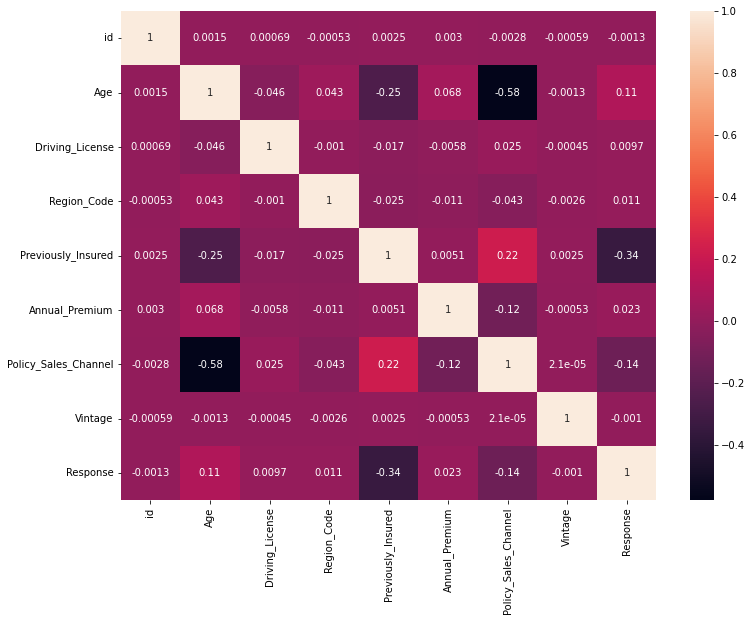

In [ ]:
df.corrwith(train["Response"]).sort_values(ascending=False)
corr_df = train.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr_df, annot=True, xticklabels=corr_df.columns, yticklabels=corr_df.columns)

corr_df = corr_df.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['1', '2']
corr_df = corr_df.reset_index()
corr_df.sort_values(by="corr", ascending=True).head(30)

high_corr = corr_df[(corr_df["corr"] >= 0.70) | (corr_df["corr"] <= -0.70)]
high_corr

FEATURE ENGINEERING

In [ ]:
train['Gender'] = train['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

In [ ]:
train['Vehicle_Damage'] = train['Vehicle_Damage'].map( {'No': 0, 'Yes': 1} ).astype(int)

In [ ]:
train=pd.get_dummies(train,drop_first=True)

In [ ]:
train.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0  1.0       1   44                1         28.0                   0   
1  2.0       1   76                1          3.0                   0   
2  3.0       1   47                1         28.0                   0   
3  4.0       1   21                1         11.0                   1   
4  5.0       0   29                1         41.0                   1   

   Annual_Premium  Policy_Sales_Channel  Vintage  Response  \
0         40454.0                  26.0      217         1   
1         33536.0                  26.0      183         0   
2         38294.0                  26.0       27         1   
3         28619.0                 152.0      203         0   
4         27496.0                 152.0       39         0   

   Vehicle_Age_lt_1_Year  Vehicle_Age_gt_2_Years  Vehicle_Damage_Yes  
0                      0                       1                   1  
1                      0                       0                   0  
2                      0                       1                   1  
3                      1                       0                   0  
4                      1                       0                   0

In [ ]:
train=train.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
train['Vehicle_Age_lt_1_Year']=train['Vehicle_Age_lt_1_Year'].astype('int')
train['Vehicle_Age_gt_2_Years']=train['Vehicle_Age_gt_2_Years'].astype('int')

In [ ]:
train["premium_age_ratio"] = train["Annual_Premium"]/train["Age"]

In [ ]:
train["premium_vintage_ratio"] = train["Annual_Premium"]/train["Vintage"]

In [ ]:
train.describe()

Age    Region_Code  Annual_Premium  Policy_Sales_Channel  \
count  3.805530e+05  380553.000000   380553.000000         380553.000000   
mean   4.988977e-17      26.388506        0.132776            112.108074   
std    1.000001e+00      13.231771        0.079877             54.176873   
min   -1.213051e+00       0.000000        0.000000              1.000000   
25%   -8.901570e-01      15.000000        0.103613             29.000000   
50%   -1.797892e-01      28.000000        0.138168            136.000000   
75%    6.597363e-01      35.000000        0.174940            152.000000   
max    2.984576e+00      52.000000        1.000000            163.000000   

            Vintage       Response  premium_age_ratio  premium_vintage_ratio  
count  3.805530e+05  380553.000000       3.805530e+05           3.805530e+05  
mean   2.550502e-17       0.122635      -1.387279e-17          -3.248810e-18  
std    1.000001e+00       0.328018       1.000001e+00           1.000001e+00  
min   -1.725142e+00       0.000000      -1.477270e+00          -6.559174e-01  
25%   -8.646331e-01       0.000000      -6.044270e-01          -4.551630e-01  
50%   -4.124408e-03       0.000000      -5.919223e-02          -3.119004e-01  
75%    8.683358e-01       0.000000       5.799505e-01           1.992284e-02  
max    1.728844e+00       1.000000       1.557803e+01           2.960968e+01

# Up_sample

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
training_data, testing_data = train.drop('Response', axis=1),train['Response']
X_train_over, y_train_over = smote.fit_resample(training_data, testing_data)

In [ ]:
y_train_over[y_train_over==1].count()

334399

In [ ]:
X_train_over.shape

(667768, 15)

Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_over, y_train_over, test_size=0.2, random_state=42)

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

ANN을 이용한  분류

In [ ]:
from keras.api._v2.keras import activations
from tensorflow.keras.layers import Embedding, Dense, Conv1D, Dropout, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from sklearn.model_selection import GridSearchCV


model = Sequential()
model.add(Dense(units = 256, activation = 'relu', input_dim = 12))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

# Compiling the ANN | means applying SGD on the whole ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
history = model.fit(X_train, y_train,
                    epochs = 30, callbacks = [es],
                    batch_size = 10,validation_split = 0.2)

score, acc = model.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)

Epoch 1/30
42803/42803 [==============================] - 225s 4ms/step - loss: 0.3344 - accuracy: 0.8397 - val_loss: 0.3160 - val_accuracy: 0.8447
Epoch 2/30
42803/42803 [==============================] - 175s 4ms/step - loss: 0.3164 - accuracy: 0.8461 - val_loss: 0.3130 - val_accuracy: 0.8449
Epoch 3/30
42803/42803 [==============================] - 175s 4ms/step - loss: 0.3132 - accuracy: 0.8477 - val_loss: 0.3109 - val_accuracy: 0.8465
Epoch 4/30
42803/42803 [==============================] - 173s 4ms/step - loss: 0.3084 - accuracy: 0.8487 - val_loss: 0.3091 - val_accuracy: 0.8467
Epoch 5/30
42803/42803 [==============================] - 173s 4ms/step - loss: 0.3049 - accuracy: 0.8499 - val_loss: 0.3085 - val_accuracy: 0.8477
Epoch 6/30
42803/42803 [==============================] - 173s 4ms/step - loss: 0.3046 - accuracy: 0.8511 - val_loss: 0.3056 - val_accuracy: 0.8496
Epoch 7/30
42803/42803 [==============================] - 172s 4ms/step - loss: 0.3009 - accuracy: 0.8522 - val_

In [ ]:
# Tuning the ANN
from keras.api._v2.keras import activations
from tensorflow.keras.layers import Embedding, Dense, Conv1D, Dropout, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def build_classifier(optimizer):
  model.add(Dense(units = 256, activation = 'relu', input_dim = 12))
  model.add(Dense(units = 256, activation = 'relu'))
  model.add(Dense(units = 128, activation = 'relu'))
  model.add(Dense(units = 128, activation = 'relu'))
  model.add(Dense(units = 32, activation = 'relu'))
  model.add(Dense(units = 32, activation = 'relu'))
  model.add(Dense(units = 1, activation = 'sigmoid'))
  model.compile(optimizer = optimizer, loss = losses.binary_crossentropy, metrics = ['accuracy'])
  return model
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [10, 20, 30, 100],
              'epochs': [30, 50,100],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train,verbose = 1)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [ ]:
print('Best Parameters after tuning: {}'.format(best_parameters))
print('Best Accuracy after tuning: {}'.format(best_accuracy))

In [ ]:
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

4180/4180 [==============================] - 8s 2ms/step
********************
13376/13376 [==============================] - 39s 3ms/step - loss: 0.3848 - accuracy: 0.8284
Test score: 0.38475388288497925
Test accuracy: 0.8284165859222412


Text(0.5, 15.0, 'Predicted label')

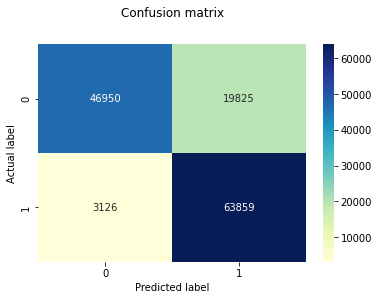

In [ ]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

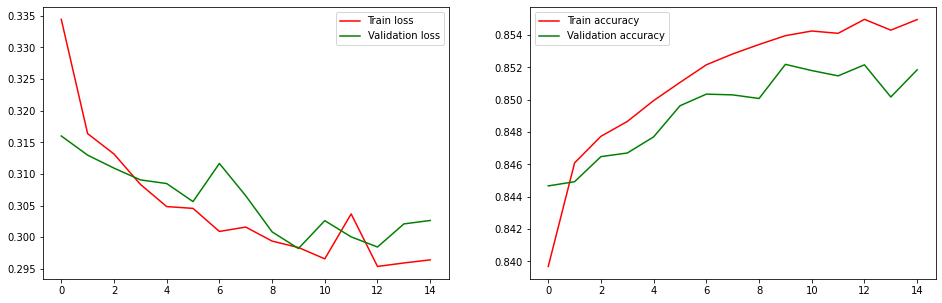

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1.plot(history.history['loss'], color='r', label='Train loss')
ax1.plot(history.history['val_loss'], color='g', label='Validation loss')
ax1.legend()

ax2.plot(history.history['accuracy'], color='r', label='Train accuracy')
ax2.plot(history.history['val_accuracy'], color='g', label='Validation accuracy')
ax2.legend()
    
plt.show()

# 모델 평가

In [ ]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(f'TN {confusion[0][0]}\t/ FP {confusion[0][1]}')
    print(f'FN {confusion[1][0]}\t/ TP {confusion[1][1]}')
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

get_clf_eval(y_test , y_pred)

오차 행렬
TN 46950	/ FP 19825
FN 3126	/ TP 63859
정확도: 0.8284, 정밀도: 0.7631, 재현율: 0.9533
